In [1]:
### Cell 1: Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import timm

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
### Cell 2: Define Paths
# Replace with your actual paths
train_path = r'D:\Sumanth_temp\Abnormal_Dataset\train'
val_path = r'D:\Sumanth_temp\Abnormal_Dataset\validation'
test_path = r'D:\Sumanth_temp\Abnormal_Dataset\test'
save_model_path = r'D:\Sumanth_temp\Models\HRNet_Abnormal_raw.pth'


In [3]:

### Cell 3: Display Dataset Statistics
def dataset_statistics(data_path):
    class_counts = {}
    for class_name in os.listdir(data_path):
        class_path = os.path.join(data_path, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

print("Train Dataset:")
print(dataset_statistics(train_path))
print("Validation Dataset:")
print(dataset_statistics(val_path))
print("Test Dataset:")
print(dataset_statistics(test_path))


Train Dataset:
{'1': 1056, '2': 1516, '3': 757, '4': 173}
Validation Dataset:
{'1': 153, '2': 212, '3': 106, '4': 27}
Test Dataset:
{'1': 296, '2': 447, '3': 223, '4': 51}


In [4]:
### Cell 4: Data Augmentation and Dataloaders
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


# Create datasets
train_dataset = datasets.ImageFolder(root=train_path, transform=transform['train'])
val_dataset = datasets.ImageFolder(root=val_path, transform=transform['val'])
test_dataset = datasets.ImageFolder(root=test_path, transform=transform['test'])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Class names: {train_dataset.classes}")


Number of classes: 4
Class names: ['1', '2', '3', '4']


In [5]:
from torch.utils.data import DataLoader
from collections import Counter
import torch.nn.functional as F

# Compute class weights
def compute_class_weights(dataset):
    class_counts = Counter([label for _, label in dataset.samples])
    total_samples = sum(class_counts.values())
    weights = {cls: total_samples / count for cls, count in class_counts.items()}
    
    # Normalize weights
    max_weight = max(weights.values())
    weights = {cls: weight / max_weight for cls, weight in weights.items()}
    
    return torch.tensor([weights[i] for i in range(len(weights))], dtype=torch.float).to(device)

class_weights = compute_class_weights(train_dataset)


In [6]:

### Cell 5: Define HRNet Model
class HRNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(HRNetClassifier, self).__init__()
        self.model = timm.create_model('hrnet_w18', pretrained=True)
        self.model.classifier = nn.Linear(self.model.num_features, num_classes)

    def forward(self, x):
        return self.model(x)

num_classes = len(train_dataset.classes)
model = HRNetClassifier(num_classes=num_classes).to(device)


In [7]:
### Cell 6: Define Training and Validation Function
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_acc, val_acc = [], []
    train_loss, val_loss = [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss, correct = 0.0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct.double() / len(train_loader.dataset)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc.item())

        # Validation phase
        model.eval()
        running_loss, correct = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = correct.double() / len(val_loader.dataset)
        val_loss.append(epoch_loss)
        val_acc.append(epoch_acc.item())

        print(f"Epoch {epoch + 1}/{num_epochs}: Train Acc: {train_acc[-1]:.2f}, Val Acc: {val_acc[-1]:.2f}")

    return train_acc, val_acc, train_loss, val_loss


In [8]:
### Cell 7: Training the Model
num_epochs = 20

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        p_t = torch.exp(-ce_loss)
        focal_loss = (1 - p_t) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Choose loss function (CrossEntropy with class weights or Focal Loss)
use_focal_loss = False  # Set True to use Focal Loss

if use_focal_loss:
    criterion = FocalLoss(alpha=class_weights)
else:
    criterion = nn.CrossEntropyLoss(weight=class_weights)

# Reduce learning rate
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_acc, val_acc, train_loss, val_loss = train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs)

# Save the trained model
torch.save(model.state_dict(), save_model_path)
print(f"Model saved to {save_model_path}")


Epoch 1/20: Train Acc: 0.50, Val Acc: 0.61
Epoch 2/20: Train Acc: 0.69, Val Acc: 0.63
Epoch 3/20: Train Acc: 0.80, Val Acc: 0.60
Epoch 4/20: Train Acc: 0.85, Val Acc: 0.63
Epoch 5/20: Train Acc: 0.91, Val Acc: 0.68
Epoch 6/20: Train Acc: 0.95, Val Acc: 0.58
Epoch 7/20: Train Acc: 0.95, Val Acc: 0.68
Epoch 8/20: Train Acc: 0.94, Val Acc: 0.58
Epoch 9/20: Train Acc: 0.96, Val Acc: 0.63
Epoch 10/20: Train Acc: 0.99, Val Acc: 0.69
Epoch 11/20: Train Acc: 0.98, Val Acc: 0.68
Epoch 12/20: Train Acc: 0.99, Val Acc: 0.67
Epoch 13/20: Train Acc: 0.97, Val Acc: 0.65
Epoch 14/20: Train Acc: 0.96, Val Acc: 0.60
Epoch 15/20: Train Acc: 0.98, Val Acc: 0.67
Epoch 16/20: Train Acc: 0.99, Val Acc: 0.68
Epoch 17/20: Train Acc: 0.99, Val Acc: 0.68
Epoch 18/20: Train Acc: 0.99, Val Acc: 0.70
Epoch 19/20: Train Acc: 0.99, Val Acc: 0.69
Epoch 20/20: Train Acc: 1.00, Val Acc: 0.69
Model saved to D:\Sumanth_temp\Models\HRNet_Abnormal_raw.pth


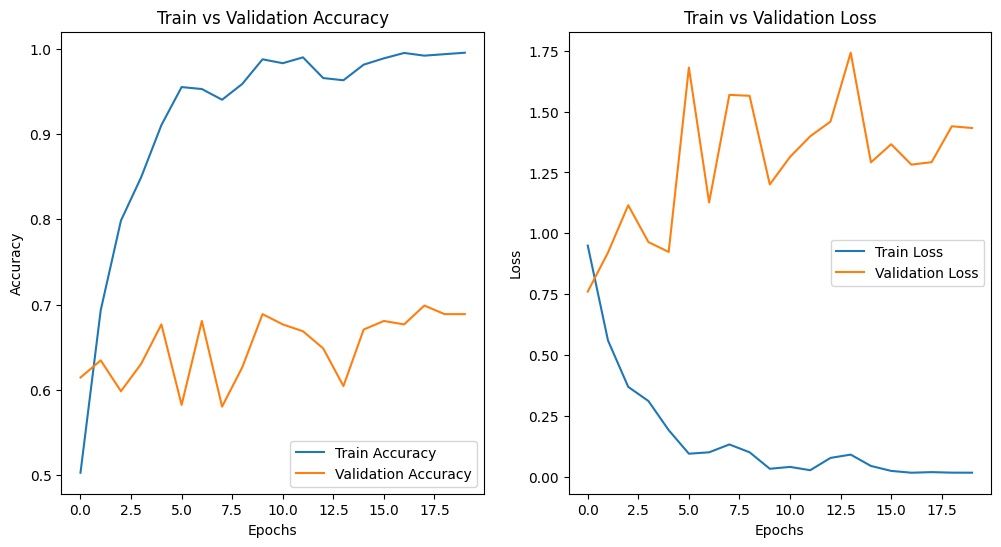

In [9]:
### Cell 8: Plot Training and Validation Graphs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss')
plt.show()


In [10]:
### Cell 9: Evaluate on Test Dataset
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

y_pred, y_true = evaluate_model(model, test_loader)


Accuracy: 0.70
Precision: 0.70
Recall: 0.70
F1 Score: 0.69

Classification Report:
              precision    recall  f1-score   support

           1       0.66      0.48      0.56       296
           2       0.65      0.80      0.72       447
           3       0.86      0.74      0.80       223
           4       0.79      0.86      0.82        51

    accuracy                           0.70      1017
   macro avg       0.74      0.72      0.72      1017
weighted avg       0.70      0.70      0.69      1017



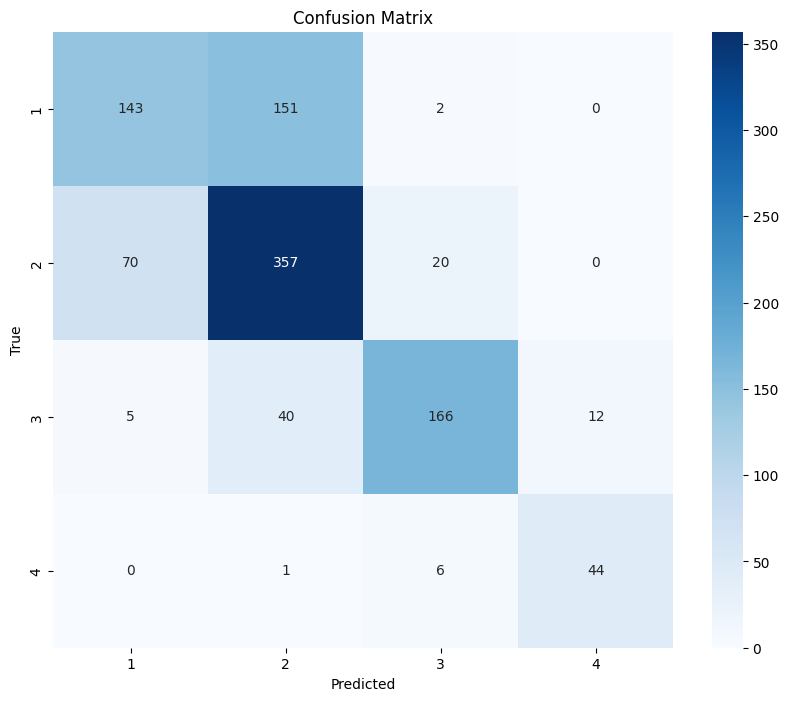

In [11]:
### Cell 10: Print Metrics and Confusion Matrix
accuracy = np.mean(y_pred == y_true)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()